# Coursework for Artificial Intelligence H COMPSCI4004 2024-2025

## Imports

In [153]:
import os, sys
import networkx as nx
from mazelib import Maze
from mazelib.generate.Prims import Prims
import numpy as np
import random as rand

import matplotlib.pyplot as plt
%matplotlib inline
from ipywidgets import interact
import ipywidgets as widgets
from IPython.display import display

import warnings
warnings.filterwarnings("ignore")

print("Python version:", sys.version)
print("Networkx version:", nx.__version__)
print("IPyWidgets version:", widgets.__version__)

Python version: 3.13.0 | packaged by Anaconda, Inc. | (main, Oct  7 2024, 21:29:38) [GCC 11.2.0]
Networkx version: 3.4.2
IPyWidgets version: 8.1.5


In [154]:
# To import the AIMA toolbox, add path the to the AIMA Python Toolbox folder on your system
AIMA_TOOLBOX_ROOT="/home/valeria/Documents/Code/aima-python-uofg_v20202021a"
sys.path.append(AIMA_TOOLBOX_ROOT)

import search as sch
from notebookutils import show_map, display_visual
# Needed to hide warnings in the matplotlib sections

## Parameters

In [155]:
N = 9 # Number of tiles on the side
M = 3 # Number of wormholes

In [156]:
# Maze will have shape (N,N) counting walls ==> N needs to be an odd number
assert N % 2 == 1, "N needs to be an odd number"
# Entrance and exit are in the walls

## Maze Generation

### Generate a random maze

In [157]:
# rand.seed(32)

In [158]:
m = Maze( )
m.generator = Prims(int(N/2), int(N/2))
m.generate()
m.generate_entrances(True, True)
print(m)
print(len(m.grid))

###E#####
# #     #
# # # # #
#   # # #
# ##### #
#   #   #
# # ### #
# # #   #
#####S###
9


In [159]:
m.grid

array([[1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 0, 1, 0, 0, 0, 0, 0, 1],
       [1, 0, 1, 0, 1, 0, 1, 0, 1],
       [1, 0, 0, 0, 1, 0, 1, 0, 1],
       [1, 0, 1, 1, 1, 1, 1, 0, 1],
       [1, 0, 0, 0, 1, 0, 0, 0, 1],
       [1, 0, 1, 0, 1, 1, 1, 0, 1],
       [1, 0, 1, 0, 1, 0, 0, 0, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1]], dtype=int8)

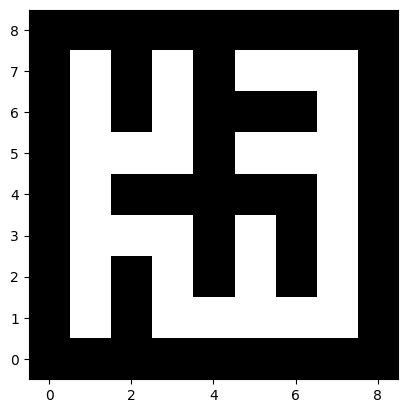

In [160]:
plt.imshow(np.logical_not(m.grid), cmap="gray", origin="lower")

### Get a grid with entrance and exit

In [161]:
maze_grid = np.logical_not(m.grid)*2
maze_grid[m.start] = 1
maze_grid[m.end] = 3
maze_grid = maze_grid.astype(np.uint8)
# Probably won't be able to have more than 2**8-3 wormholes

n = len(maze_grid)

In [162]:
maze_grid

array([[0, 0, 0, 3, 0, 0, 0, 0, 0],
       [0, 2, 0, 2, 2, 2, 2, 2, 0],
       [0, 2, 0, 2, 0, 2, 0, 2, 0],
       [0, 2, 2, 2, 0, 2, 0, 2, 0],
       [0, 2, 0, 0, 0, 0, 0, 2, 0],
       [0, 2, 2, 2, 0, 2, 2, 2, 0],
       [0, 2, 0, 2, 0, 0, 0, 2, 0],
       [0, 2, 0, 2, 0, 2, 2, 2, 0],
       [0, 0, 0, 0, 0, 1, 0, 0, 0]], dtype=uint8)

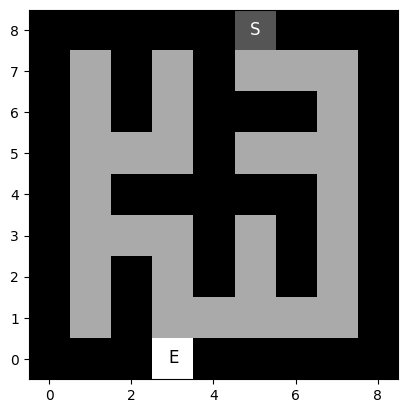

In [163]:
plt.imshow(maze_grid, cmap="gray", origin="lower")
for (j, i), label, color in zip([m.start, m.end], ["S","E"], ["w", "k"]):
    plt.text(i-.1, j-.1, label, color=color, fontsize="large")

### Generate wormholes

#### Some helper functions

In [164]:
def square2flat(i, j, N):
    """From indices in a square array, to index in flatten array"""
    return i*N + j

def flat2square(k, N):
    """From indices in a flatten array, to index in square array"""
    return (k // N, k % N)

def square_neighbours(k, N):
    """Return neighbours in a squared array while working with flatten indices"""
    i, j = flat2square(k, N)
    neighbours = []
    if i>0: neighbours.append(k-N)
    if i<N-1: neighbours.append(k+N)
    if j>0: neighbours.append(k-1)
    if j<N-1: neighbours.append(k+1)
    return neighbours    

In [165]:
index = square2flat(8,8,N)

print("Flat index", index)
print("Square array indices", flat2square(index, N))
print("Neighbours' flat indices", square_neighbours(index, N))
print("Neighbours' square indices", [flat2square(k, N) for k in square_neighbours(index, N)])

Flat index 80
Square array indices (8, 8)
Neighbours' flat indices [71, 79]
Neighbours' square indices [(7, 8), (8, 7)]


#### Wormhole indices selection

In [166]:
# Available tiles for wormhole entrances
indices_available = np.where(maze_grid.flatten()==2)[0].tolist()
n_available = len(indices_available)
assert n_available >= 2*M, "Not enough empty tiles for that many wormholes"


In [167]:
# Randomize positions
rand.shuffle(indices_available)

# Make sure that wormholes are not formed between neighbours
wormholes = []
filled = False
while not filled:
    if len(wormholes)%2 == 0:
        add_candidate = True
    else:
        if indices_available[0] not in square_neighbours(index, wormholes[-1]):
            add_candidate = True
        else: add_candidate = False
    if add_candidate:
        wormholes.append( indices_available.pop(0) )
    else:
        indices_available.append( indices_available.pop(0) )
    filled = len(wormholes) == 2*M

In [168]:
wormholes

[68, 51, 57, 43, 21, 23]

In [169]:
[flat2square(w_k, N) for w_k in wormholes]

[(7, 5), (5, 6), (6, 3), (4, 7), (2, 3), (2, 5)]

### Visualization

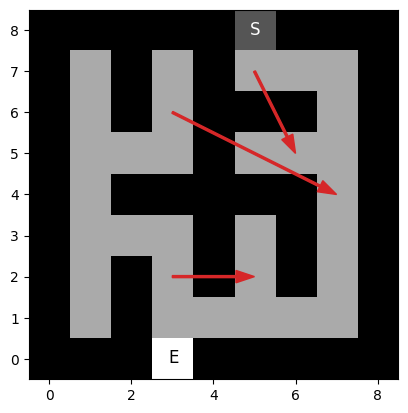

In [170]:
plt.imshow(maze_grid, cmap="gray", origin="lower")
for w_k in range(M):
    i_start, j_start = flat2square(wormholes[2*w_k], N)
    i_end, j_end = flat2square(wormholes[2*w_k+1], N)
    plt.arrow(j_start, i_start, j_end-j_start, i_end-i_start,
              width=0.05, head_width=0.3, length_includes_head=True,
              color="C3")
for (j, i), label, color in zip([m.start, m.end], ["S","E"], ["w", "k"]):
    plt.text(i-.1, j-.1, label, color=color, fontsize="large")

### Graph representation of the maze

In [171]:
tile2str = lambda i, j : f"S_{i:02d}_{j:02d}"

In [172]:
network_dict = {}
map_locations = {}
for i in range(N):
    for j in range(N):
        if maze_grid[i,j]: 
            cell_dict = {}
            if i>0 and maze_grid[i-1,j]: cell_dict[ tile2str(j,i-1) ] = 1
            if i<N-1 and maze_grid[i+1,j]: cell_dict[ tile2str(j,i+1) ] = 1
            if j>0 and maze_grid[i,j-1]: cell_dict[ tile2str(j-1,i) ] = 1
            if j<N-1 and maze_grid[i,j+1]: cell_dict[ tile2str(j+1,i) ] = 1
            network_dict[ tile2str(j,i) ] = cell_dict
            map_locations[ tile2str(j,i) ] = (j,i)

maze_start = tile2str(*m.start[::-1])
maze_end = tile2str(*m.end[::-1])

In [173]:
if M>0:
    for w_k in range(M):
        i_start, j_start = flat2square(wormholes[2*w_k], N)
        i_end, j_end = flat2square(wormholes[2*w_k+1], N)
        network_dict[ tile2str(j_start,i_start) ][ tile2str(j_end,i_end) ] = 1

In [174]:
network_dict

{'S_03_00': {'S_03_01': 1},
 'S_01_01': {'S_01_02': 1},
 'S_03_01': {'S_03_00': 1, 'S_03_02': 1, 'S_04_01': 1},
 'S_04_01': {'S_03_01': 1, 'S_05_01': 1},
 'S_05_01': {'S_05_02': 1, 'S_04_01': 1, 'S_06_01': 1},
 'S_06_01': {'S_05_01': 1, 'S_07_01': 1},
 'S_07_01': {'S_07_02': 1, 'S_06_01': 1},
 'S_01_02': {'S_01_01': 1, 'S_01_03': 1},
 'S_03_02': {'S_03_01': 1, 'S_03_03': 1, 'S_05_02': 1},
 'S_05_02': {'S_05_01': 1, 'S_05_03': 1},
 'S_07_02': {'S_07_01': 1, 'S_07_03': 1},
 'S_01_03': {'S_01_02': 1, 'S_01_04': 1, 'S_02_03': 1},
 'S_02_03': {'S_01_03': 1, 'S_03_03': 1},
 'S_03_03': {'S_03_02': 1, 'S_02_03': 1},
 'S_05_03': {'S_05_02': 1},
 'S_07_03': {'S_07_02': 1, 'S_07_04': 1},
 'S_01_04': {'S_01_03': 1, 'S_01_05': 1},
 'S_07_04': {'S_07_03': 1, 'S_07_05': 1},
 'S_01_05': {'S_01_04': 1, 'S_01_06': 1, 'S_02_05': 1},
 'S_02_05': {'S_01_05': 1, 'S_03_05': 1},
 'S_03_05': {'S_03_06': 1, 'S_02_05': 1},
 'S_05_05': {'S_06_05': 1},
 'S_06_05': {'S_05_05': 1, 'S_07_05': 1},
 'S_07_05': {'S_07_0

In [175]:
map_locations

{'S_03_00': (3, 0),
 'S_01_01': (1, 1),
 'S_03_01': (3, 1),
 'S_04_01': (4, 1),
 'S_05_01': (5, 1),
 'S_06_01': (6, 1),
 'S_07_01': (7, 1),
 'S_01_02': (1, 2),
 'S_03_02': (3, 2),
 'S_05_02': (5, 2),
 'S_07_02': (7, 2),
 'S_01_03': (1, 3),
 'S_02_03': (2, 3),
 'S_03_03': (3, 3),
 'S_05_03': (5, 3),
 'S_07_03': (7, 3),
 'S_01_04': (1, 4),
 'S_07_04': (7, 4),
 'S_01_05': (1, 5),
 'S_02_05': (2, 5),
 'S_03_05': (3, 5),
 'S_05_05': (5, 5),
 'S_06_05': (6, 5),
 'S_07_05': (7, 5),
 'S_01_06': (1, 6),
 'S_03_06': (3, 6),
 'S_07_06': (7, 6),
 'S_01_07': (1, 7),
 'S_03_07': (3, 7),
 'S_05_07': (5, 7),
 'S_06_07': (6, 7),
 'S_07_07': (7, 7),
 'S_05_08': (5, 8)}

Important personal interpretation
- I am assuming that going down a teleportation link is optional: e.g. in (2,1) it's possible to go right, go left, or go down the teleportation link.
- I am assuming that the wormholes are two-ways passages: e.g. from (2,1) you can go down the teleportation link to (0,7), and from (0,7) you can go back to (2,1).


- Environment? Besides being discrete and static, it is...
    - Deterministic, because wormholes might lead to an unknown state, but they always lead to the same state with 100% probability.
    - Partially observable, because it is not known from the percepts where the "teleport" action is going to take the agent.
- Actuators? Move the agent according to 5 possible actions:
    - Left
    - Right
    - Up
    - Down
    - Teleport
- Percepts? 
    - Current x,y location
    - Feasibility of all 5 actions, expressed by booleans (l,r,u,d,t)
- Sensors? Incomplete because...
    - The agent knows to which state the (Left, Right, Up, Down) actions take it
    - But the agent does not know to which state the (Teleport) action takes it
- Performance measure? The sortest the path to goal, the better (in terms of steps taken from the start point)

In [176]:
maze_map = sch.Graph(network_dict)
maze_map.locations = map_locations

In [177]:
print("Unique states/nodes (i.e.locations) and possible actions in those states:\n") 
print(maze_map.locations) 

Unique states/nodes (i.e.locations) and possible actions in those states:

{'S_03_00': (3, 0), 'S_01_01': (1, 1), 'S_03_01': (3, 1), 'S_04_01': (4, 1), 'S_05_01': (5, 1), 'S_06_01': (6, 1), 'S_07_01': (7, 1), 'S_01_02': (1, 2), 'S_03_02': (3, 2), 'S_05_02': (5, 2), 'S_07_02': (7, 2), 'S_01_03': (1, 3), 'S_02_03': (2, 3), 'S_03_03': (3, 3), 'S_05_03': (5, 3), 'S_07_03': (7, 3), 'S_01_04': (1, 4), 'S_07_04': (7, 4), 'S_01_05': (1, 5), 'S_02_05': (2, 5), 'S_03_05': (3, 5), 'S_05_05': (5, 5), 'S_06_05': (6, 5), 'S_07_05': (7, 5), 'S_01_06': (1, 6), 'S_03_06': (3, 6), 'S_07_06': (7, 6), 'S_01_07': (1, 7), 'S_03_07': (3, 7), 'S_05_07': (5, 7), 'S_06_07': (6, 7), 'S_07_07': (7, 7), 'S_05_08': (5, 8)}


#### Visualization

In [178]:
# node colors, node positions and node label positions
node_colors = {node: 'white' for node in maze_map.locations.keys()}
node_positions = maze_map.locations
node_label_pos = { k:[v[0],v[1]-.3]  for k,v in maze_map.locations.items() }
edge_weights = {(k, k2) : v2 for k, v in maze_map.graph_dict.items() for k2, v2 in v.items()}

maze_graph_data = {  'graph_dict' : maze_map.graph_dict,
                        'node_colors': node_colors,
                        'node_positions': node_positions,
                        'node_label_positions': node_label_pos,
                        'edge_weights': edge_weights
                     }

print("Done creating the graph object")

Done creating the graph object


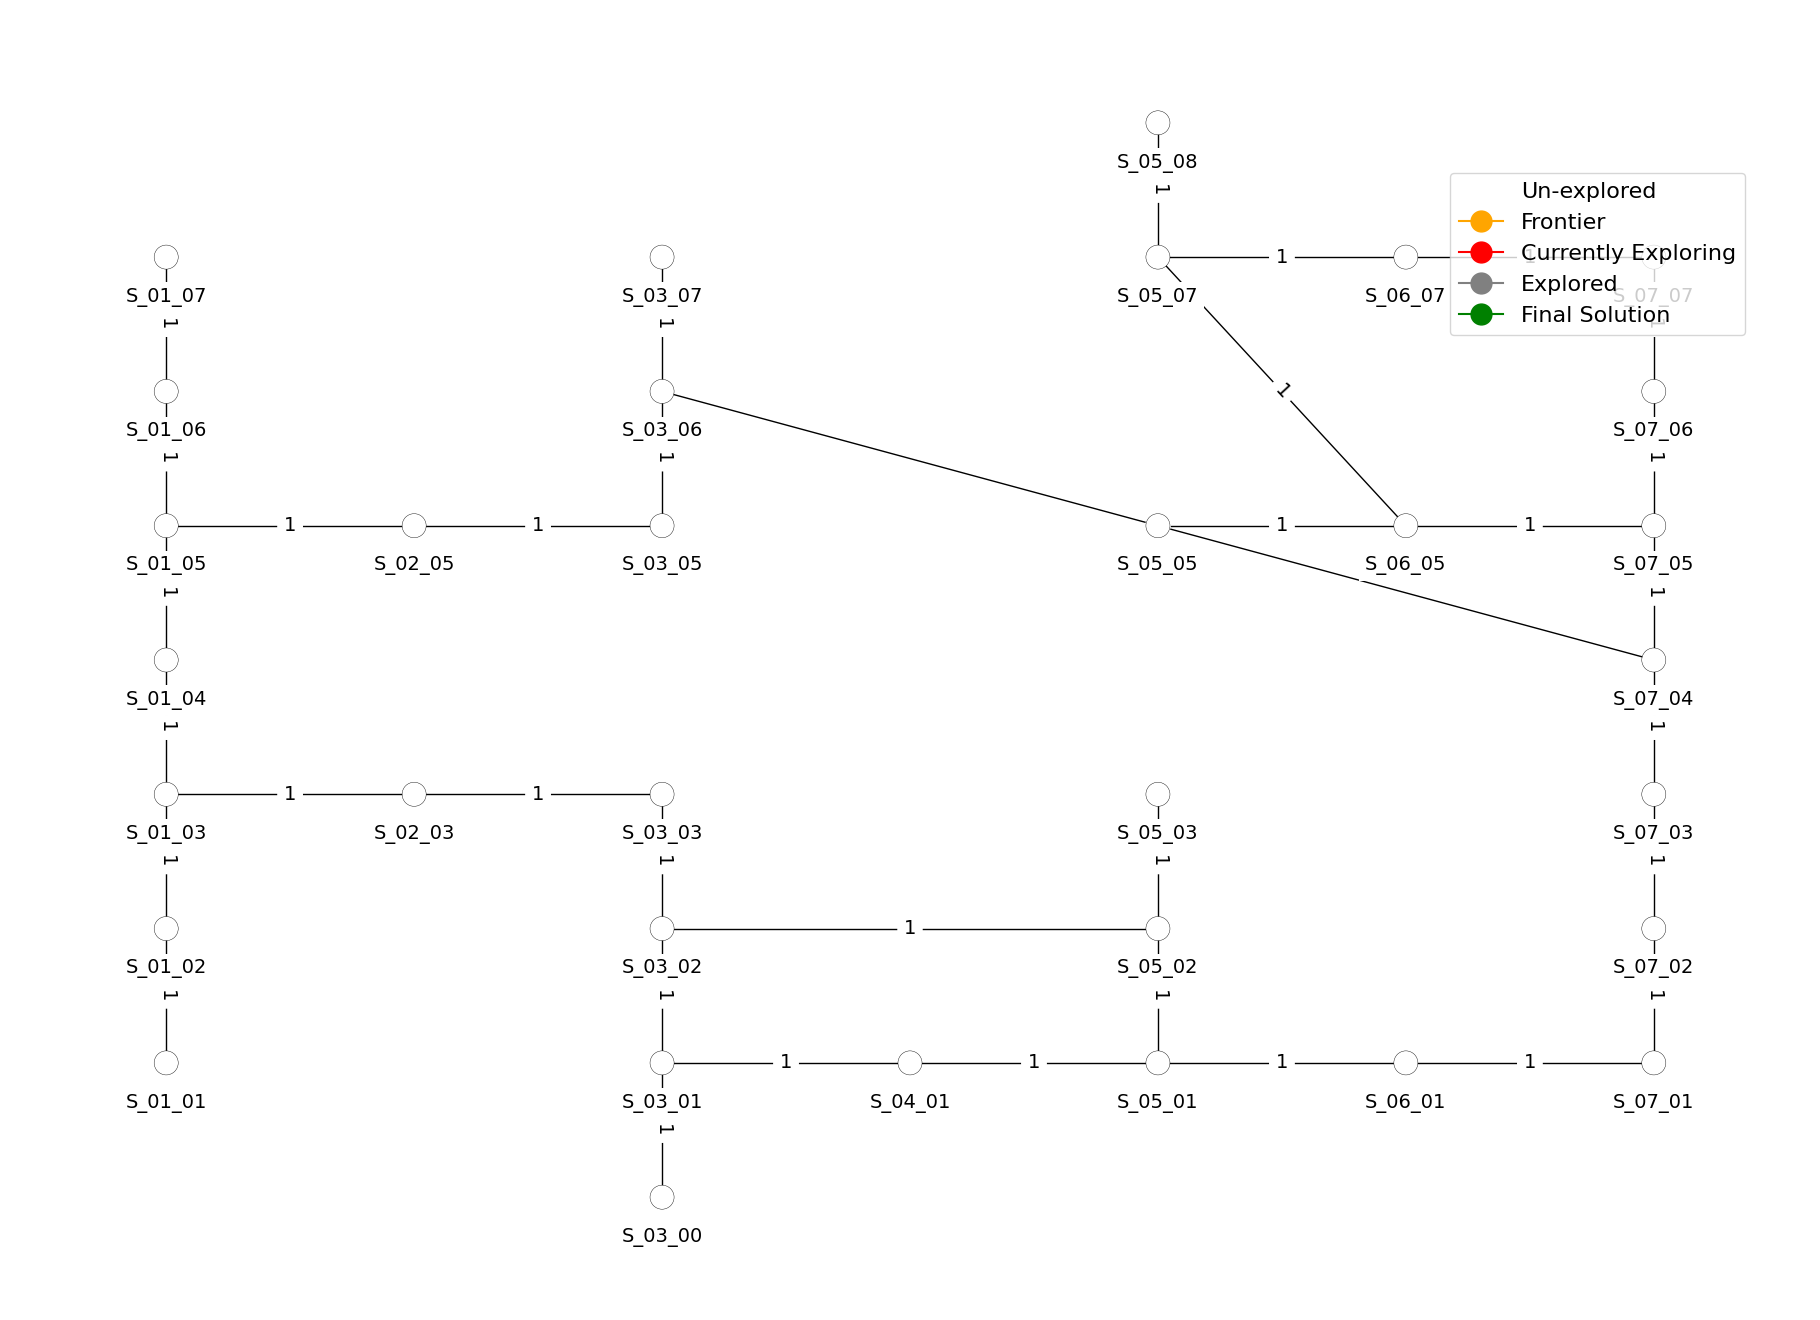

In [179]:
show_map(maze_graph_data)

## Solving the problem

### Define the A-star search function

The cells below copy the A* implementation from Lab 3, using helper functions from the AIMA toolbox.


In [180]:
def my_best_first_graph_search_for_vis(problem, f):
    """Search the nodes with the lowest f scores first.
    You specify the function f(node) that you want to minimize; for example,
    if f is a heuristic estimate to the goal, then we have greedy best
    first search; if f is node.depth then we have breadth-first search.
    There is a subtlety: the line "f = memoize(f, 'f')" means that the f
    values will be cached on the nodes as they are computed. So after doing
    a best first search you can examine the f values of the path returned.
    
    Credits to the AI Module lecturers: this function has been 
    taken from Lab 3 and it has not been modified"""
    
    # we use these two variables at the time of visualisations
    iterations = 0
    all_node_colors = []
    node_colors = {k : 'white' for k in problem.graph.nodes()}
    
    f = sch.memoize(f, 'f')
    node = sch.Node(problem.initial)
    
    node_colors[node.state] = "red"
    iterations += 1
    all_node_colors.append(dict(node_colors))
    
    if problem.goal_test(node.state):
        node_colors[node.state] = "limegreen"
        iterations += 1
        all_node_colors.append(dict(node_colors))
        return(iterations, all_node_colors, node)
    
    frontier = sch.PriorityQueue('min', f)
    frontier.append(node)
    
    node_colors[node.state] = "orange"
    iterations += 1
    all_node_colors.append(dict(node_colors))
    
    explored = set()
    while frontier:
        node = frontier.pop()
        
        node_colors[node.state] = "red"
        iterations += 1
        all_node_colors.append(dict(node_colors))
        
        if problem.goal_test(node.state):
            node_colors[node.state] = "limegreen"
            node_colors[problem.initial] = "limegreen"
            for extra_node in node.solution():
                node_colors[extra_node] = "limegreen"  
            iterations += 1
            all_node_colors.append(dict(node_colors))
            return(iterations, all_node_colors, node)
        
        explored.add(node.state)
        for child in node.expand(problem):
            if child.state not in explored and child not in frontier:
                frontier.append(child)
                node_colors[child.state] = "orange"
                iterations += 1
                all_node_colors.append(dict(node_colors))
            elif child in frontier:
                incumbent = frontier[child]
                if f(child) < f(incumbent):
                    del frontier[incumbent]
                    frontier.append(child)
                    node_colors[child.state] = "orange"
                    iterations += 1
                    all_node_colors.append(dict(node_colors))

        node_colors[node.state] = "gray"
        iterations += 1
        all_node_colors.append(dict(node_colors))
    return None


In [181]:
def my_astar_search_graph(problem, h=None):
    """A* search is best-first graph search with f(n) = g(n)+h(n).
    You need to specify the h function when you call astar_search, or
    else in your Problem subclass.
    
    Credits to the AI Module lecturers: this function has been 
    taken from Lab 3 and it has not been modified"""
    h = sch.memoize(h or problem.h, 'h')
    iterations, all_node_colors, node = my_best_first_graph_search_for_vis(problem, 
                                                                lambda n: n.path_cost + h(n))
    return(iterations, all_node_colors, node)

## Alternative solution

### Define the problem with a different distance

According to the current setup...
- Cost function f = Accumulated path length, with each step uniformly assigned length 1 (wormholes included)
- Heuristic function h = Euclidian straight-line distance to the maze exit

However, to better represent the estimated remaining distance to the goal, I decided to use a different distance metric: the sum $|x_{goal}-x| + |y_{goal}-y|$ of the vertical and horizontal distances.

The A-star algorithm will always reach optimal solution if the heuristic function is admissible. Meaning 

In [186]:
class SquareAngleDistanceGraphProblem(sch.GraphProblem):
    """The problem of searching a graph from one node to another."""

    def __init__(self, *args, verbose=False):
        super().__init__(*args)
        self.verbose = verbose

    def h(self, node):
        """The sum of the horizontal and vertical distance to the goal"""
        locs = getattr(self.graph, 'locations', None)
        if locs:
            if type(node) is str:
                state_position = np.array(locs[node])
            else:
                state_position = np.array(locs[node.state])
            goal_position = np.array(locs[self.goal])
            if self.verbose: 
                print("State position", state_position)
                print("Distance to the goal", int( np.sum( np.abs( goal_position - state_position) ) ))
            return int( np.sum( np.abs( goal_position - state_position) ) )
        else:
            return sch.infinity

In [187]:
maze_problem = SquareAngleDistanceGraphProblem(maze_start, maze_end, maze_map, verbose=True)

print("Initial state: " + maze_problem.initial)
print("Goal state: "    + maze_problem.goal)

Initial state: S_05_08
Goal state: S_03_00


### Run the solver

In [188]:
all_node_colors=[]
iterations, all_node_colors, node = my_astar_search_graph(problem=maze_problem, h=None)

#-- Trace the solution --#
solution_path = [node]
cnode = node.parent
solution_path.append(cnode)
while cnode.state != maze_start:
    cnode = cnode.parent  
    solution_path.append(cnode)

print("----------------------------------------")
print("Identified goal state:"+str(solution_path[0]))
print("----------------------------------------")
print("Solution trace:"+str(solution_path))
print("----------------------------------------")


State position [5 8]
Distance to the goal 10
State position [5 7]
Distance to the goal 9
State position [5 8]
Distance to the goal 10
State position [6 7]
Distance to the goal 10
State position [6 5]
Distance to the goal 8
State position [5 5]
Distance to the goal 7
State position [7 5]
Distance to the goal 9
State position [6 5]
Distance to the goal 8
State position [5 7]
Distance to the goal 9
State position [7 7]
Distance to the goal 11
State position [7 4]
Distance to the goal 8
State position [7 6]
Distance to the goal 10
State position [6 5]
Distance to the goal 8
State position [7 3]
Distance to the goal 7
State position [7 5]
Distance to the goal 9
State position [7 2]
Distance to the goal 6
State position [7 4]
Distance to the goal 8
State position [7 1]
Distance to the goal 5
State position [7 3]
Distance to the goal 7
State position [7 2]
Distance to the goal 6
State position [6 1]
Distance to the goal 4
State position [5 1]
Distance to the goal 3
State position [7 1]
Distan

### Visualization

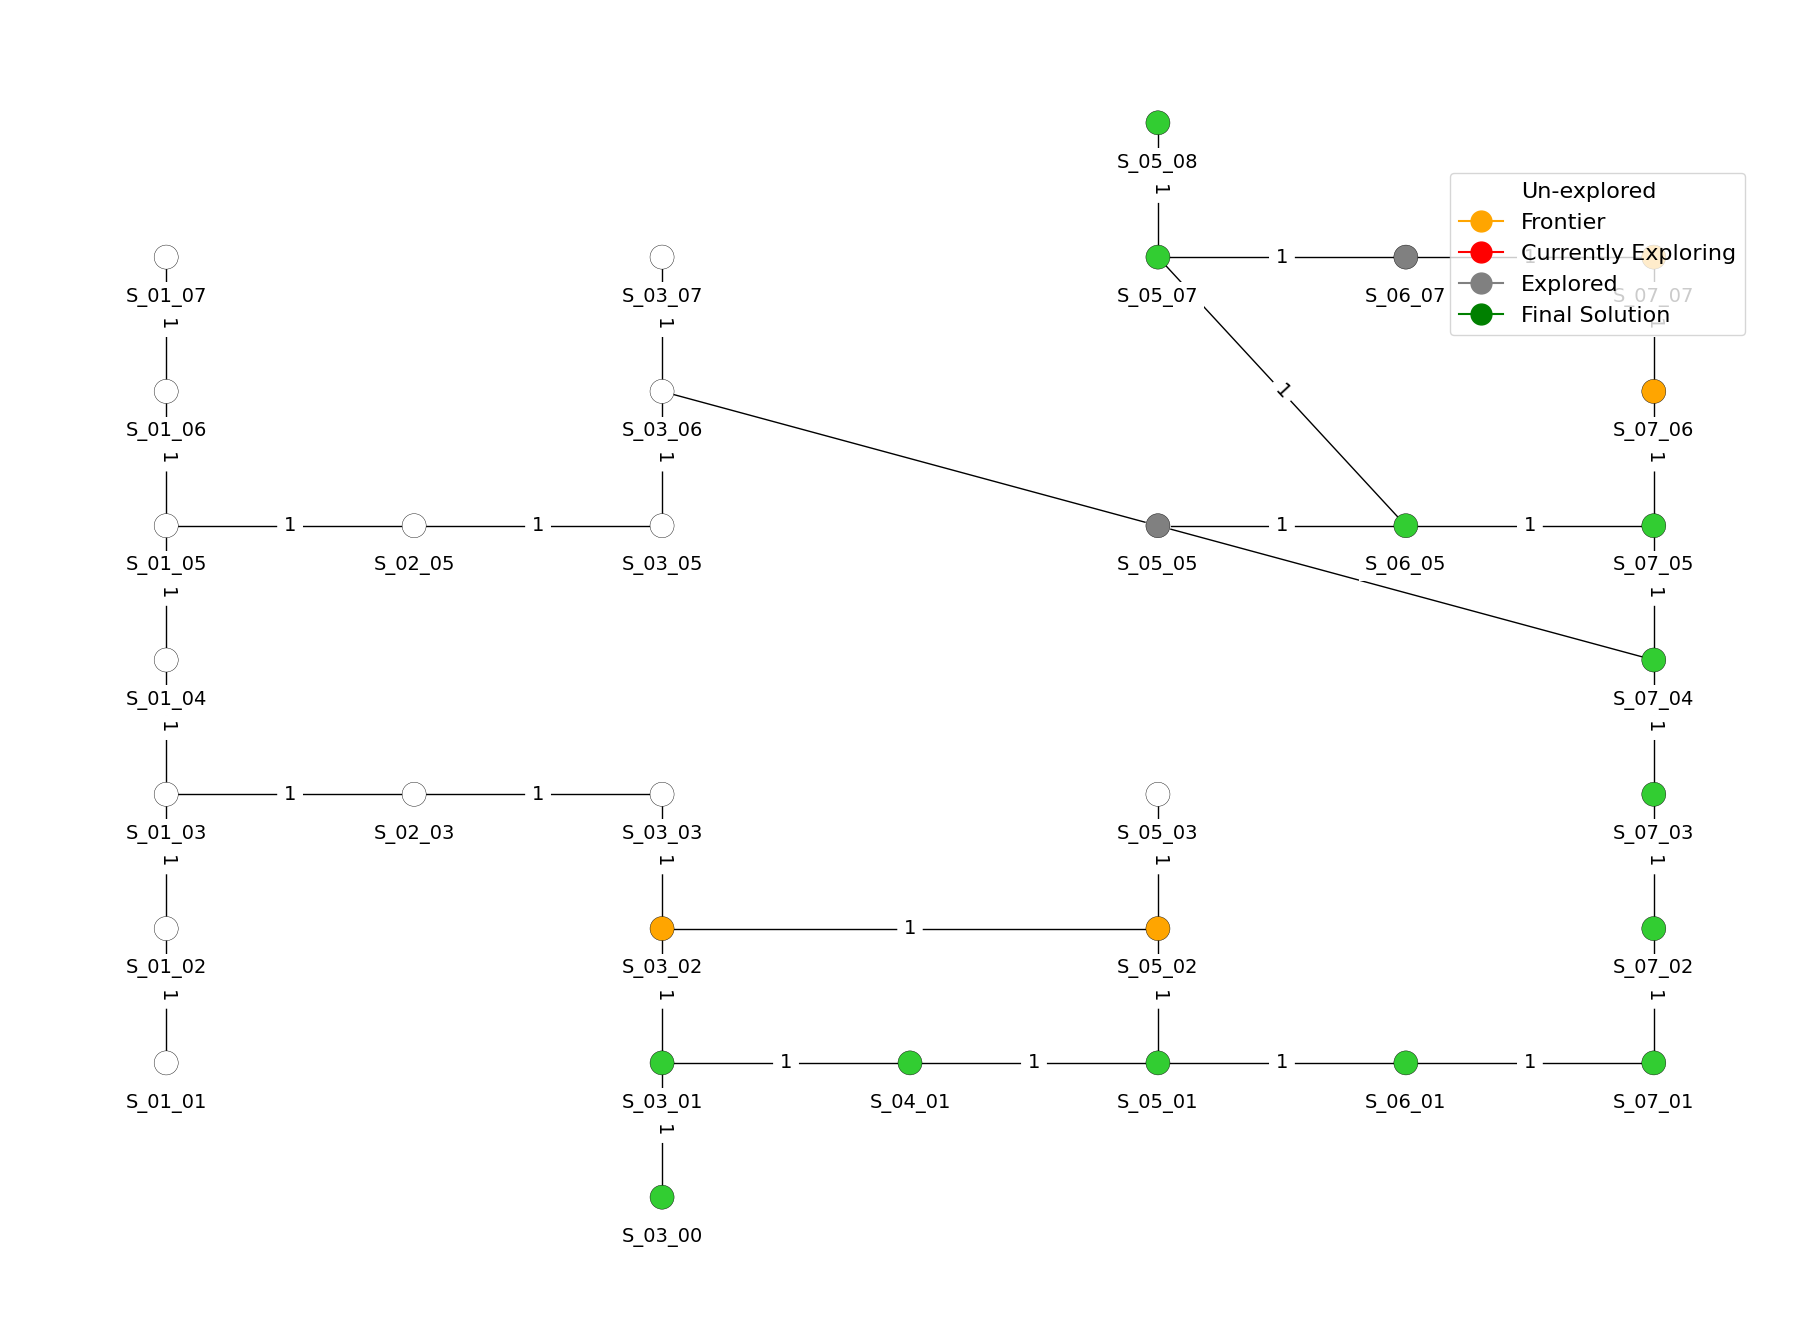

In [189]:
final_maze_graph_data = dict(maze_graph_data)
final_maze_graph_data["node_colors"] = all_node_colors[-1]

show_map(final_maze_graph_data)

In [190]:
do_full_visualization = True
if do_full_visualization:     
    # WARNING the FULL visualisation might not work very well on some computers due to 
    # the large graph and the many iterations required.The visualisaiton will 
    # typically compute the solution and do the plotting at the end - and it often takes a long time ...
    #
    print("::: Full Visualization ::::")
    all_node_colors = []        
    display_visual(maze_graph_data, user_input=False, 
               algorithm=my_astar_search_graph, 
               problem=maze_problem)

::: Full Visualization ::::


interactive(children=(IntSlider(value=0, description='iteration', max=1), Output()), _dom_classes=('widget-int…

interactive(children=(ToggleButton(value=False, description='Visualize'), Output()), _dom_classes=('widget-int…

### Analysis

Apparently, the solution is still not always optimal:

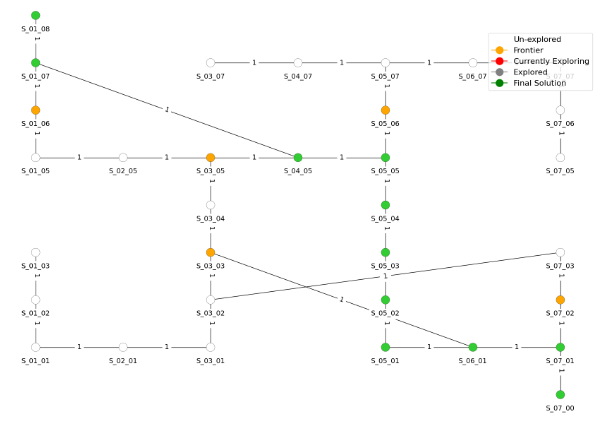

The problem is that it is now sometimes useful to take one step back and get further away from the objective, because there are some shortcuts closeby that are not in the same direction as the goal.